# FY 20 Growth Model Updates

Goal: Evaluate historical data from the past four fiscal years (FY16 -FY19) to determine more accurate averages for the following metrics: 

* Year to year high school retention rate
    * i.e. The percent of students who continue on from their Junior to Sophomore year. 
* Year to year college retntion rate
    * i.e. The percent of students who continue on from their four year to fifth year.
      * Note, this report will treat graduates and inactive students as the same. For example, 100 students are enrolled in their 4th year of college. At the start of their fifth year, 50 students have graduated, and 20 have dropped out (became inactive). The retention rate for 4th -> 5th year will be 30%.
* Updated college graduation rates by high school class

In [11]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import numpy as np


import seaborn as sns 
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
sns.set_style("white")



In [2]:
%matplotlib inline

In [3]:
today = datetime.today()
in_file = Path.cwd() / "data" / "processed" / "processed_data.pkl"
in_file2 = Path.cwd() / "data" / "processed" / "processed_data_file2.pkl"
in_file3 = Path.cwd() / "data" / "processed" / "processed_data_file3.pkl"

active_students = Path.cwd() / "data" / "processed" / "active_students.pkl"

report_dir = Path.cwd() / "reports"
report_file = report_dir / "Excel_Analysis_{today:%b-%d-%Y}.xlsx"

In [4]:
df = pd.read_pickle(in_file)

df2 = pd.read_pickle(in_file2)

df3 = pd.read_pickle(in_file3)

df_active_students = pd.read_pickle(active_students)


In [5]:
total_enrollent_df = df_active_students.groupby(
    ["Site", "Global Academic Year", "enrollment_target"], as_index=False
).sum()

In [6]:
total_enrollent_df = total_enrollent_df.pivot_table(
    index=["enrollment_target", "Site"], values="active_student", aggfunc="mean"
)

In [7]:
total_enrollent_df= total_enrollent_df.reset_index().sort_values('active_student')

## High School Data

### Chart 1. Average Total High School Enrollment
This shows the average total enrollment at each site, broken out by each site's enrollment target. 

Using the prior logic, a site would meet their enrollment target if they retained 100% of their freshman, and sophomore students, 95% of their juniors, and 88% of their seniors. This would result in the following total numbers:

* 75 Student Enrollment Target: 287
* 60 Student Enrollment Target: 230 
 

As we can see in the following chart, only San Francisco and New Orleans averaged hitting their full enrollment target in the past four years. 

Note, The Durant Center only has one cohort of students, which did exceed their cohort target. 

In [9]:
total_enrollent_df.at[5, 'Site'] = 'PGC'
total_enrollent_df.at[2, 'Site'] = 'EPA'

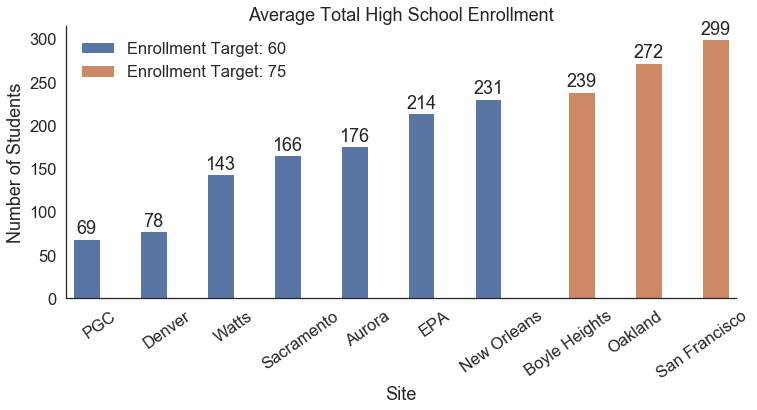

In [43]:
fig, ax = plt.subplots(figsize=(12,5))


g = sns.barplot(data = total_enrollent_df, hue='enrollment_target',
               x='Site', y='active_student', ax=ax)


g.set_xticklabels(g.get_xticklabels(), rotation=35)
g.set_title('Average Total High School Enrollment')

g.set_xlabel('Site')
g.set_ylabel('Number of Students')

ax.legend(loc='best', frameon=False)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

sns.despine()

### Chart 2. Average High School Enrollment By Grade Level

This chart shows the average enrollment by each grade level, broken out by the enrollment target for sites.

Key notes:

* The general enrollment pattern is almost identical regardless of a site's cohort target. This means we can make more general enrollment projections. 
* Sites tend to increase their enrollment from Freshman to Sophomore year, with a small drop off from Sophomore to Junior year, but then a major (17%) decline from Junior to Senior year. 

In [13]:
by_grade_df = df_active_students.groupby(
    ["Site", "Grade (AT)", "Global Academic Year", "enrollment_target"], as_index=False
).sum()

# removing grades with less than 5 students as this could skew the results

by_grade_df = by_grade_df[by_grade_df.active_student > 5]



In [14]:
grade_order = ["9th Grade", "10th Grade", "11th Grade", "12th Grade"]

by_grade_df_table = by_grade_df.pivot_table(
    index=["enrollment_target","Grade (AT)"], values="active_student", aggfunc="mean"
)

by_grade_df_table["pct_change"] = by_grade_df_table[
    "active_student"
].pct_change()

by_grade_df_table =  by_grade_df_table.reindex(grade_order, level='Grade (AT)')

In [15]:
by_grade_df_table = by_grade_df_table.reset_index()

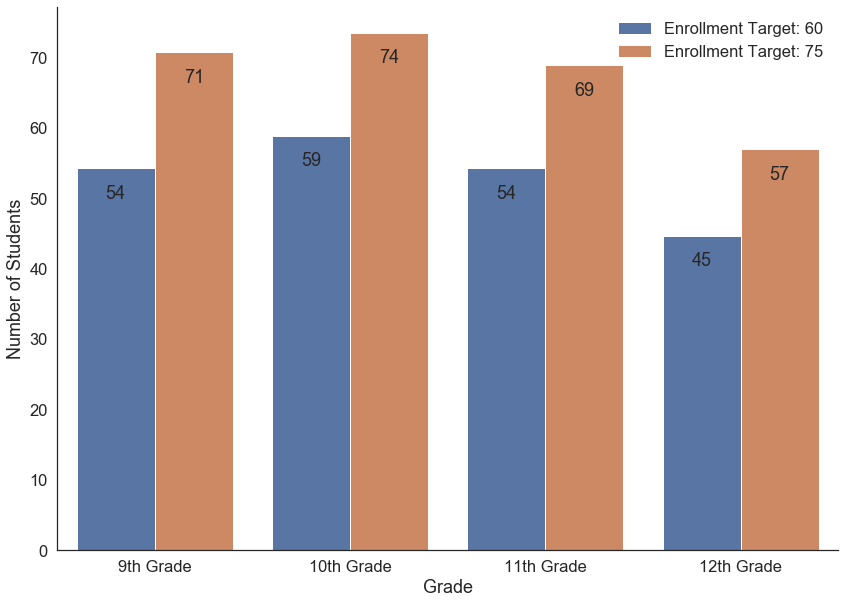

In [50]:
fig, ax = plt.subplots(figsize=(14,10))

g = sns.barplot(data = by_grade_df_table, hue='enrollment_target',
               x='Grade (AT)', y='active_student', ax=ax)

g.set_xlabel('Grade')
g.set_ylabel('Number of Students')
ax.legend(loc='best', frameon=False)


sns.despine()

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()-5), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


## College Data

### Chart 3. Average College Enrollment By Region and College Year
 
These charts display the average college enrollment for the sites contained in each CT region. More mature regions, NOLA and Nor Cal, clearly have a similar trend in college numbers compared to younger regions. 

In [17]:
ps_year_count = df3.pivot_table(
    index=["enrollment_target", "Region", "Site", "High School Class", "Grade (AT)"],
    columns="active_student",
    values="18 Digit ID",
    aggfunc="count",
)

In [18]:
ps_year_count = ps_year_count.sort_values(
    by=["enrollment_target", "Site", "High School Class"]
)

In [19]:
ps_year_count_grouped = ps_year_count.groupby(["Region", "Grade (AT)"]).mean()
# ps_year_count_grouped['change'] = ps_year_count_grouped[True].pct_change()*100
ps_year_count_grouped["change"] = (
    ps_year_count_grouped.groupby("Region")[True].pct_change().round(2) * 100
)


In [20]:
ps_year_count_grouped = ps_year_count_grouped.reset_index()

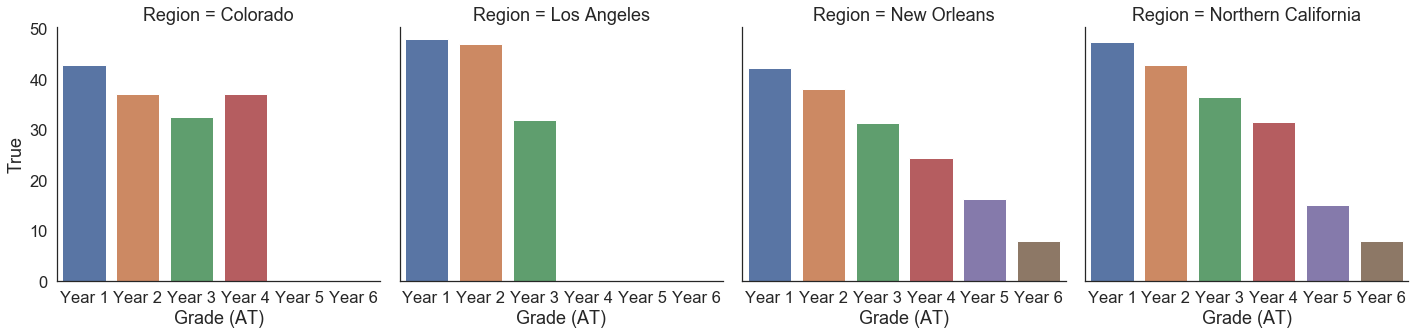

In [35]:

sns.catplot(data=ps_year_count_grouped, x='Grade (AT)', y=True , col='Region', kind='bar');

### Chart 4. Cohort Graduation Rates

In [25]:
def create_rate_table(df, groupings, level, columns):
    _table = (
        df.groupby(groupings)
        .agg({i: "value_counts" for i in df.columns[columns]})
        .groupby(level=0)
        .transform(lambda x: x)
    )
    _table = _table.groupby(level=list(range(level))).transform(lambda x: x / x.sum())

    _table = _table.drop(index=[False, "NA"], level=level)
    _table = _table.droplevel(level)
    return _table

In [33]:
grad_rates_class = create_rate_table(df2, ["High School Class"], 1, list(range(4, 8)))

grad_rates_class.round(2)

,Graduated: 4-Year Degree <=4 years,Graduated: 4-Year Degree <=5 years,Graduated: 4-Year Degree <=6 years,Graduated: 4-Year Degree
2001,0.11,0.33,0.56,0.72
2002,0.57,0.64,0.64,0.86
2003,0.28,0.48,0.56,0.80
2004,0.50,0.57,0.67,0.73
2005,0.23,0.37,0.40,0.47
2006,0.23,0.36,0.41,0.55
2007,0.25,0.41,0.52,0.59
2008,0.33,0.52,0.60,0.62
2009,0.26,0.39,0.44,0.61
2010,0.18,0.38,0.41,0.52


In [30]:
grad_rates_region = create_rate_table(df2, ["Region"], 1, list(range(4, 8)))
grad_rates_region.round(2)

,Graduated: 4-Year Degree <=4 years,Graduated: 4-Year Degree <=5 years,Graduated: 4-Year Degree <=6 years,Graduated: 4-Year Degree
Colorado,0.34,0.43,0.43,0.43
New Orleans,0.21,0.28,0.32,0.34
Northern California,0.31,0.45,0.48,0.54


## Recommendations / Decision Points

The previous version of the growth model actually had reasonably accurate assumptions for high school classes. The only major area it was off was Freshman recruitment rarely hit the total target, but Sophomore year backfill usually returned sites to near capacity. 

The model was much more inaccurate when it came to college. Using historical data, the number of students dropping between Year 2 and Year 3 was much higher than originally estimated, as was the number of students either graduating or dropping after Year 4. 

In [64]:
growth_model_assumptions = [1, 1, .85, .75, .75, .73, .67, .57, .43, .3]

In [65]:
average_rates = [54/60,59/60,54/60,45/60, 44/60, .69, .55, .51,.29,.14]

In [77]:
rate_comparison = pd.DataFrame(np.array([growth_model_assumptions, average_rates]),
             columns=['Freshman', 'Sophomore', 'Junior', 'Senior', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5', 'Year 6'], index=['Growth Model Assumptions', 'Historical Averages'])

In [87]:
rate_comparison.round(2)

,Freshman,Sophomore,Junior,Senior,Year 1,Year 2,Year 3,Year 4,Year 5,Year 6
Growth Model Assumptions,1.0,1.00,0.85,0.75,0.75,0.73,0.67,0.57,0.43,0.30
Historical Averages,0.9,0.98,0.90,0.75,0.73,0.69,0.55,0.51,0.29,0.14


In [88]:
# Year 2 Calculation
pre_year_rate = .75
previous_year = 60*pre_year_rate

this_year_rate = .085
# previous_year * (1-this_year_rate) / 60

In [89]:
# Year 3 Calculation
pre_year_rate = .69
previous_year = 60*pre_year_rate

this_year_rate = .1925
# previous_year * (1-this_year_rate) / 60


In [90]:
# Year 3 Calculation
pre_year_rate = .55
previous_year = 60*pre_year_rate

this_year_rate = .07
# previous_year * (1-this_year_rate) / 60


In [91]:
# Year 5 Calculation
pre_year_rate = .51
previous_year = 60*pre_year_rate

this_year_rate = .43
# previous_year * (1-this_year_rate) / 60


In [92]:
# Year 6 Calculation
pre_year_rate = .29
previous_year = 60*pre_year_rate

this_year_rate = .49
# previous_year * (1-this_year_rate) / 60


In [96]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>
<style>
div.prompt {display:none}
</style>